# Mega Yolo -- train the model

## Some toggles for if you want to re-start from weights

In [1]:
# Do you want to re-run from an already generated train/valid/test split?
#  -- this is useful for feature testing and/or re-starting from weights
re_run_from_splits = True

# if restarting, how many previous log files do we want to look at?
#####nRecent = 7 # for the 1st restart, this will be 1, for the 2nd, 2, etc

# set to true if you are not re-running from the same dataset
regenAnchors = False
 
# use a saved weights file? Set to None if not and training will start anew
#saved_weights_file = 'weights/savedWeights/training_1_model_l0.017813377.h5'
saved_weights_file = None

#fileStorage = 'binaries/' # binaries is where things are -- MAIN   
#extraName = '' # append to training weights name

# for feature collections
#fileStorage = 'binaries_model8_tfrecordz/'
#extraName = 'model8_tfrec'

fileStorage = 'binaries_model7_tfrecordz/'
extraName = 'model7_tfrec'

In [2]:
# toggle for if on google collab or not
import os
thisDir = os.getcwd()
onGoogle = False
if 'content' in thisDir: onGoogle = True

In [3]:

# Mount Google Drive
if onGoogle: # probably on google
    from google.colab import drive
    drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
if onGoogle: # probably on google
    # find config
    # from pathlib import Path
    # for path in Path('./').rglob('config.py'):
    #     if path.name == 'config.py':
    #         continue
    #print(path)
    if not os.path.exists("/content/gdrive/My Drive/Colab Notebooks/scienceDigitization/"):
        print("ERROR: path does not exist")
    os.chdir("/content/gdrive/My Drive/Colab Notebooks/scienceDigitization/")
    import config

    print('On google')
    
    classDirMain = './'
    figCapMain = './'
    
    yoloWeightDir = classDirMain + 'classifications/'

    weightsDir = classDirMain + 'classifications/'
    logsDir = classDirMain + 'classifications/'

    classDirMain = './classifications/'
    classDirMainHOME = fileStorage 
    splitsDir = './classifications/'
    logsDir = classDirMain
    chksDir = classDirMain
    saveFile = classDirMain + 'weights/testList.csv'
else:
    print('on laptop')
    import config
    classDirMain = config.save_binary_dir #+ fileStorage
    #figCapMain = '/Users/jillnaiman/Dropbox/wwt_image_extraction/ClassifyingImages/'
    #from sys import path; path.append('/Users/jillnaiman/scienceDigitization/')
    # where are raw images?
    images_pulled_dir = config.images_jpeg_dir #'/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Pages/RandomSingleFromPDFIndexed/' ## what about Dropbox though????
    yoloWeightDir = config.save_weights_dir
    #weightsDir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/mega_yolo/saved_weights/' # weights/
    logsDir = config.save_weights_dir #'/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/mega_yolo/' # weights/
    classDirMainHOME = fileStorage 
    # note -- we are generally not running locally, so this is really tmp storage
    splitsDir = config.tmp_storage_dir #'/Users/jillnaiman/tmpModels/mega_yolo/'
    weightsDir = splitsDir
    logsDir = splitsDir
    chksDir = splitsDir
    saveFile = config.tmp_storage_dir + 'testList.csv'
    # make if not there
    if not os.path.exists(weightsDir+'weights/'):
        os.makedirs(weightsDir+'weights/')


On google


In [5]:
# # some parameters for different architectures of YOLO
batch_size = 10 #32, might be possible, 10 was what we had before
buffer_size = 50
num_epochs = 150 #150 #300

In [6]:
weightsDir

'./classifications/'

In [7]:
# where annotations and features files
classDir_main_to = classDirMain + config.ann_name + str(int(config.IMAGE_H)) + 'x' + str(int(config.IMAGE_W))  + '_ann/'

classDir_main_to_imgs = classDirMain + fileStorage.split('/')[-2] + '/'
classDir_main_to, classDir_main_to_imgs

('./classifications/yolo_512x512_ann/',
 './classifications/binaries_model7_tfrecordz/')

In [8]:
import os
import glob
import re
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.cElementTree as ET

# make more better?
#from numba import jit
from time import perf_counter
import sys

# for v5
import math
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import layers

In [9]:
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
import tensorflow.keras.backend as K
import imgaug as ia
from imgaug import augmenters as iaa

# my imports
import pickle
import pandas as pd
from PIL import Image
import json
from scipy import stats
import shutil

# for restart
from tensorflow.python.summary.summary_iterator import summary_iterator
import struct
from datetime import date as DATE

from tensorflow.keras.utils import Progbar
import time 


# get parse
from mega_yolo_utils import build_model, train_test_valid_split, \
    process_box, process_layer, box_iou, compute_nms, iou, num_cluster, generator, \
    get_n_features
from general_utils import parse_annotation

Tensorflow version : 2.7.0
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## First, data setup

In data pre-processing (`generate_features_only.py`) TF records files are created.

In [10]:
train_list = glob.glob(classDir_main_to_imgs + 'train_*tfrecords')
valid_list = glob.glob(classDir_main_to_imgs + 'valid_*tfrecords')
#test_list = glob.glob(classDir_main_to_imgs + 'test_*tfrecords')
train_list[:5]

['./classifications/binaries_model7_tfrecordz/train_3.tfrecords',
 './classifications/binaries_model7_tfrecordz/train_8.tfrecords',
 './classifications/binaries_model7_tfrecordz/train_5.tfrecords',
 './classifications/binaries_model7_tfrecordz/train_2.tfrecords',
 './classifications/binaries_model7_tfrecordz/train_9.tfrecords']

In [11]:
# get raw data
#train_raw_data = tf.data.TFRecordDataset(train_list)
#valid_raw_data = tf.data.TFRecordDataset(valid_list)

# for compressed
train_raw_data = tf.data.TFRecordDataset(filenames=train_list, 
                                         compression_type='GZIP', 
                                         buffer_size=None, 
                                        num_parallel_reads=tf.data.AUTOTUNE)
valid_raw_data = tf.data.TFRecordDataset(filenames=valid_list, 
                                         compression_type='GZIP', 
                                         buffer_size=None,
                                        num_parallel_reads=tf.data.AUTOTUNE)

In [12]:
# Create a dictionary describing the features.
image_feature_description = {
    'nbox': tf.io.FixedLenFeature([], tf.float32),
    'nfeatures': tf.io.FixedLenFeature([], tf.float32),
    'boxes': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
}

If we don't have access to anchors file and train/test/valid files -- read from splits.  Either way, get the labels from a file.

In [13]:
LABELS = np.loadtxt(classDir_main_to_imgs + 'LABELS.csv', 
                    dtype=str, delimiter=',')
CLASS = len(LABELS)
labels = np.arange(0,len(LABELS))

In [14]:
# if we have anchors already
def _parse_just_boxes(example_proto):
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    # parse the data
    nboxes = image_features['nbox']
    nfeatures = image_features['nfeatures']
    boxes = tf.io.decode_raw(image_features['boxes'],tf.float32)
    boxes = tf.reshape(boxes,[nboxes,5])  
    return boxes

In [15]:
if re_run_from_splits: regenAnchors = False

if regenAnchors:
#if True:
    boxes = train_raw_data.map(lambda example_proto:_parse_just_boxes(example_proto))
    saved_boxes = []
    for ib,b in enumerate(boxes):
        if ib%500 == 0: print('on', ib, 'of ? (probably 5000ish for full)')
        saved_boxes.append(b.numpy())
    # valid
    boxes = valid_raw_data.map(lambda example_proto:_parse_just_boxes(example_proto))
    for ib,b in enumerate(boxes):
        if ib%500 == 0: print('on', ib, 'of ? (probably 5000*0.15ish for valid)')
        saved_boxes.append(b.numpy())

In [16]:
# assume location of saved anchors:
saveFileAnchors = classDirMain + 'weights/anchors.pickle'
# hack for local debugging
if '/Users/jillnaiman' in thisDir:
    saveFileAnchors = splitsDir + 'anchors.pickle'

if regenAnchors:
#if True:
    boxes = []
    for bb in saved_boxes:
        if len(bb) > 0:
            for b in bb:
                boxes.append([b[2]-b[0], b[3]-b[1]])
    boxes = np.array(boxes)
    
    anchors = generator(boxes,k=num_cluster)
    print('NEW ANCHORS:')
    
    # save!
    with open(saveFileAnchors, 'wb') as ff:
        pickle.dump(anchors, ff)
else:
    print('from saved:')
    with open(saveFileAnchors, 'rb') as f:
        anchors = pickle.load(f)    
    
print(anchors)

from saved:
[[195.  21.]
 [203.   7.]
 [ 51.   5.]
 [313. 199.]
 [359. 391.]
 [435.  16.]
 [399. 307.]
 [204. 114.]
 [ 15. 355.]]


Take a look at what is in each TFRecord file:

In [17]:
# if we have anchors already
def _parse_to_view(example_proto,anchors,CLASS):
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    # parse the data
    nboxes = image_features['nbox']
    nfeatures = image_features['nfeatures']
    boxes = tf.io.decode_raw(image_features['boxes'],tf.float32)
    boxes = tf.reshape(boxes,[nboxes,5])
    images_raw = image_features['image_raw']
    image = tf.io.decode_raw(images_raw,tf.float32)
    image = tf.reshape(image,[config.IMAGE_H,config.IMAGE_W,nfeatures]) 
    return image,nboxes,nfeatures,boxes

In [18]:
#view_dataset = train_raw_data.map(lambda example_proto:_parse_to_view(example_proto,
#                                                                      anchors,CLASS))
# view_dataset = train_raw_data.interleave(lambda example_proto:
#     train_raw_data.map(_parse_to_view(example_proto,anchors,CLASS), num_parallel_calls=tf.data.AUTOTUNE),
#     cycle_length=4, block_length=16)

view_dataset = train_raw_data.interleave(lambda x: train_raw_data.map(lambda example_proto:_parse_to_view(example_proto, anchors,CLASS),num_parallel_calls=tf.data.AUTOTUNE))

# dataset = tf.data.Dataset.from_tensor_slices(filenames)
# def parse_fn(filename):
#   return tf.data.Dataset.range(10)
# dataset = dataset.interleave(lambda x:
#     tf.data.TextLineDataset(x).map(parse_fn, num_parallel_calls=1),
#     cycle_length=4, block_length=16)

nboxes= tf.Tensor(2.0, shape=(), dtype=float32)
nfeatures= tf.Tensor(10.0, shape=(), dtype=float32)
boxes= tf.Tensor(
[[ 39.  37. 447. 464.   1.]
 [233. 467. 252. 470.   2.]], shape=(2, 5), dtype=float32)


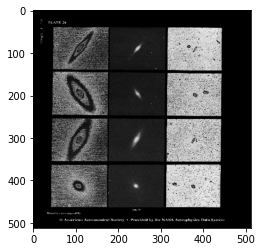

In [19]:
# check one out
for image,nboxes,nfeatures,boxes in view_dataset.take(1):
    imgPlot = image.numpy()
    plt.imshow(imgPlot[:,:,0],cmap='gray')
    print('nboxes=',nboxes)
    print('nfeatures=',nfeatures)
    print('boxes=',boxes)

In [20]:
# # debug
# import mega_yolo_utils
# from importlib import reload
# reload(mega_yolo_utils)
# from mega_yolo_utils import process_box

In [21]:
# if we have anchors already
def _parse_image_function(example_proto,anchors,CLASS):
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    # parse the data
    nboxes = image_features['nbox']
    nfeatures = image_features['nfeatures']
    boxes = tf.io.decode_raw(image_features['boxes'],tf.float32)
    boxes = tf.reshape(boxes,[nboxes,5])
    images_raw = image_features['image_raw']
    image = tf.io.decode_raw(images_raw,tf.float32)
    image = tf.reshape(image,[config.IMAGE_H,config.IMAGE_W,nfeatures])
    # process boxes -- wrap in a tf.py_function
    y1,y2,y3 = tf.py_function(process_box,
                              (boxes[:,:4], boxes[:,4],anchors,CLASS),
                              (tf.float32,tf.float32,tf.float32))   
    return image, y1,y2,y3

In [22]:
#train_dataset = train_raw_data.map(lambda example_proto:_parse_image_function(example_proto,
#                                                                              anchors,CLASS))
train_dataset = train_raw_data.interleave(lambda x: train_raw_data.map(lambda example_proto:_parse_image_function(example_proto, 
                                                                                                                  anchors,CLASS),
                                                                       num_parallel_calls=tf.data.AUTOTUNE))

# valid_dataset = valid_raw_data.map(lambda example_proto:_parse_image_function(example_proto,
#                                                                               anchors,CLASS))
valid_dataset = valid_raw_data.interleave(lambda x: valid_raw_data.map(lambda example_proto:_parse_image_function(example_proto, 
                                                                                                                  anchors,CLASS),
                                                                       num_parallel_calls=tf.data.AUTOTUNE))


In [23]:
# ***** ADD TRAINING AUGMENTATION HERE JUST FOR TRAINING SET ********

In [24]:
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [25]:
valid_dataset = valid_dataset.shuffle(buffer_size)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

(10, 512, 512, 10)


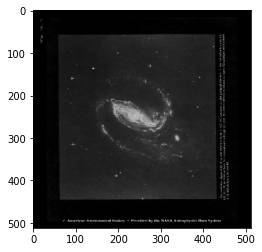

In [26]:
# check one out, but only if you wanna
for image,y1,y2,y3 in train_dataset.take(1):
    imgPlot = image.numpy()
    print(imgPlot.shape)
    plt.imshow(imgPlot[0,:,:,0],cmap='gray')
    #print(y1)

In [27]:
# Grab annotations to calculate steps... sometimes this can take a bit...
annotations = glob.glob(classDir_main_to + '*')
len(annotations)

5515

In [28]:
labels, LABELS

(array([0, 1, 2, 3]),
 array(['figure', 'figure caption', 'math formula', 'table'], dtype='<U14'))

Steps per epoch -- training:

In [29]:
# debug
# from importlib import reload
# reload(config)

In [30]:
# guestimate based on splits
len_train = len(annotations)*config.train_per
len_valid = len(annotations)*config.valid_per

In [31]:
#steps = len(X_train) // batch_size
#print(len(X_train)//batch_size)
# can do larger with augmentation

#aug_fac = 2 # 2 or 3

aug_fac = 1 # set to 1 if no data aug

steps_training = int((len_train//batch_size)*aug_fac)
# factor of 2 from: https://stackoverflow.com/questions/49922252/choosing-number-of-steps-per-epoch

steps_val = int((len_valid//batch_size)*aug_fac)

print('Steps per epoch = training:', steps_training, ', validation:', steps_val)

Steps per epoch = training: 413 , validation: 82


# 1. Define YOLO model

For v5, see: https://github.com/jahongir7174/YOLOv5-tf

For creating the model -- how many features are we using:

In [32]:
# if we have anchors already
def _parse_nfeatures(example_proto):
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    # parse the data
    nfeatures = image_features['nfeatures']
    return nfeatures

In [33]:
nfeatures_data = train_raw_data.map(lambda example_proto:_parse_nfeatures(example_proto))
n_features = -1
for f in nfeatures_data.take(1):
    n_features = int(f.numpy())
n_features

10

Build YOLOv5:

In [34]:
tf.keras.backend.clear_session()
version = 'l' # large version
model = build_model(n_features, anchors, version, len(LABELS))

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                0)]                                                               
                                                                                                  
 tf.nn.space_to_depth (TFOpLamb  (None, 256, 256, 40  0          ['input_1[0][0]']                
 da)                            )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  23040       ['tf.nn.space_to_depth[0][0]']   
                                )                                                             

In [36]:
# plot if you wanna
#tf.keras.utils.plot_model(model_v5, "yolo_v5.png", show_shapes=True, show_layer_names=True, expand_nested=False)

For optimizer:

In [37]:
LRrate = 0.004
#LRrate = 0.002

class CosineLR(tf.optimizers.schedules.LearningRateSchedule):
    def __init__(self,steps):
        super().__init__()
        self.lr = LRrate * batch_size / 64
        self.warmup_init = LRrate/10.
        self.warmup_step = steps
        self.decay_steps = tf.cast((num_epochs - 1) * self.warmup_step, tf.float32)

    def __call__(self, step):
        linear_warmup = tf.cast(step, dtype=tf.float32) / self.warmup_step * (self.lr - self.warmup_init)
        cosine_lr = 0.5 * self.lr * (1 + tf.cos(math.pi * tf.cast(step, tf.float32) / self.decay_steps))
        return tf.where(step < self.warmup_step, self.warmup_init + linear_warmup, cosine_lr)

    def get_config(self):
        pass

In [38]:
optimizer = tf.keras.optimizers.Adam(CosineLR(steps_training), 0.937)

In [39]:
# load weights if you wanna
if saved_weights_file is not None:
    weightsFiles = glob.glob(weightsDir + 'weights/' + '*h5')
    # OR
    if saved_weights_file is not None:
      weightsFiles = [classDirMain+saved_weights_file]
    model.load_weights(weightsFiles[0])

In [40]:
#print(weightsFiles)
optimizer.learning_rate.lr

0.000625

# For processing data:

Including Augmentation like a boss!

In [41]:
######aug_train_dataset = augmentation_generator(train_dataset, anchors, CLASS)
aug_train_dataset = train_dataset

For calculating the loss:

In [42]:
class ComputeLoss(object):
    def __init__(self):
        super().__init__()

    @staticmethod
    def compute_loss(y_pred, y_true, anchors):
        grid_size = tf.shape(y_pred)[1:3]
        ratio = tf.cast(tf.constant([config.IMAGE_W, config.IMAGE_H]) / grid_size, tf.float32)
        batch_size = tf.cast(tf.shape(y_pred)[0], tf.float32)

        x_y_offset, pred_boxes, pred_conf, pred_prob = process_layer(y_pred, anchors,CLASS)

        object_mask = y_true[..., 4:5]

        def cond(idx, _):
            return tf.less(idx, tf.cast(batch_size, tf.int32))

        def body(idx, mask):
            valid_true_boxes = tf.boolean_mask(y_true[idx, ..., 0:4],
                                               tf.cast(object_mask[idx, ..., 0], 'bool'))
            iou = box_iou(pred_boxes[idx], valid_true_boxes)
            return idx + 1, mask.write(idx, tf.cast(tf.reduce_max(iou, axis=-1) < 0.2, tf.float32))

        ignore_mask = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
        
        #print('here1.1')
        #print(cond, body, ignore_mask)

        _, ignore_mask = tf.while_loop(cond=cond, body=body, loop_vars=[0, ignore_mask])
        
        #print('here1.2')
        ignore_mask = ignore_mask.stack()
        ignore_mask = tf.expand_dims(ignore_mask, -1)

        true_xy = y_true[..., 0:2] / ratio[::-1] - x_y_offset
        pred_xy = pred_boxes[..., 0:2] / ratio[::-1] - x_y_offset

        true_tw_th = y_true[..., 2:4] / anchors
        pred_tw_th = pred_boxes[..., 2:4] / anchors
        true_tw_th = tf.where(tf.equal(true_tw_th, 0), tf.ones_like(true_tw_th), true_tw_th)
        pred_tw_th = tf.where(tf.equal(pred_tw_th, 0), tf.ones_like(pred_tw_th), pred_tw_th)
        true_tw_th = tf.math.log(tf.clip_by_value(true_tw_th, 1e-9, 1e+9))
        pred_tw_th = tf.math.log(tf.clip_by_value(pred_tw_th, 1e-9, 1e+9))

        box_loss_scale = y_true[..., 2:3] * y_true[..., 3:4]
        # note -- assumes IMAGE_H == IMAGE_W
        box_loss_scale = 2. - box_loss_scale / tf.cast(config.IMAGE_H ** 2, tf.float32)

        xy_loss = tf.reduce_sum(tf.square(true_xy - pred_xy) * object_mask * box_loss_scale)
        wh_loss = tf.reduce_sum(tf.square(true_tw_th - pred_tw_th) * object_mask * box_loss_scale)

        conf_pos_mask = object_mask
        conf_neg_mask = (1 - object_mask) * ignore_mask
        conf_loss_pos = conf_pos_mask * tf.nn.sigmoid_cross_entropy_with_logits(labels=object_mask, logits=pred_conf)
        conf_loss_neg = conf_neg_mask * tf.nn.sigmoid_cross_entropy_with_logits(labels=object_mask, logits=pred_conf)
        # try this
        #conf_loss_pos = conf_pos_mask * -tf.reduce_sum(object_mask*tf.math.log(tf.clip_by_value(pred_conf,1e-10,1.0)))
        #conf_loss_neg = conf_neg_mask * -tf.reduce_sum(object_mask*tf.math.log(tf.clip_by_value(pred_conf,1e-10,1.0)))


        conf_loss = tf.reduce_sum((conf_loss_pos + conf_loss_neg))

        true_conf = y_true[..., 5:]

        class_loss = object_mask * tf.nn.sigmoid_cross_entropy_with_logits(true_conf, pred_prob)
        #class_loss = object_mask * -tf.reduce_sum(true_conf*tf.math.log(tf.clip_by_value(pred_conf,1e-10,1.0)))
        #class_loss = object_mask * tf.losses.categorical_crossentropy(true_conf, pred_prob)
        #tf.losses.sparse_softmax_cross_entropy(y, logits)
        class_loss = tf.reduce_sum(class_loss) # sum across all -- 1 number for loss

        if np.isnan(xy_loss):
          print('xy_loss is NaN')
        if np.isnan(wh_loss):
          print('wh_loss is NaN')
        if np.isnan(conf_loss):
          print('conf_loss is NaN')#, conf_loss_pos, conf_loss_neg)
        if np.isnan(class_loss):
          print('class_loss is NaN')

        if np.isnan(xy_loss + wh_loss + conf_loss + class_loss):
          print('--- object mask ---')
          print(object_mask.numpy().shape, pred_conf.numpy().shape, true_conf.numpy().shape)
          print(object_mask.numpy().max(), object_mask.numpy().min())
          print(object_mask)
          print(' ')
          print('--------')
        #else:
        #  print(object_mask.numpy().max(), object_mask.numpy().min())

        return xy_loss + wh_loss + conf_loss + class_loss

    def __call__(self, y_pred, y_true):
        loss = 0.
        anchor_group = [anchors[6:9], anchors[3:6], anchors[0:3]]

        for i in range(len(y_pred)):
            loss += self.compute_loss(y_pred[i], y_true[i], anchor_group[i])
        return loss

In [43]:
loss_object = ComputeLoss()

In [44]:
def compute_loss(y_true, y_pred):
    total_loss = loss_object(y_pred, y_true)
    return tf.reduce_sum(total_loss) / batch_size

In [45]:
def train_step(image, y_true):
    with tf.GradientTape() as tape:
        y_pred = model(image, training=True)
        #print(y_pred[0].shape, y_true[0].shape)
        loss = compute_loss(y_true, y_pred)
    if not np.isnan(loss):
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        #if np.isnan(loss):
        #  print('nan')
        #  print
        optimizer.apply_gradients(zip(gradients, variables))
    else: # this will stop if we have non-convergence 
        print('is NaN -- probably want to lower your learning rate!!!!')
        import sys; sys.exit()
    return loss

In [46]:
# save weights
def save_best_weights(model, name, val_loss_avg):
    # delete existing weights file
    files = glob.glob(os.path.join(weightsDir + 'weights/', name + '*'))
    for file in files:
        os.remove(file)
    # create new weights file
    name = name + '_model_' +version + str(val_loss_avg) + '.h5'
    path_name = os.path.join(weightsDir +'weights/', name)
    model.save_weights(path_name)
    
    
# log (tensorboard)
def log_loss(loss, val_loss, step):
    tf.summary.scalar('loss', loss, step)
    tf.summary.scalar('val_loss', val_loss, step)

In [47]:
# training
def train(epochs, model, train_dataset, val_dataset, steps_per_epoch_train, 
          steps_per_epoch_val, optimizer, train_name = 'train'):
    '''
    Train YOLO model for n epochs.
    Eval loss on training and validation dataset.
    Log training loss and validation loss for tensorboard.
    Save best weights during training (according to validation loss).

    Parameters
    ----------
    - epochs : integer, number of epochs to train the model.
    - model : YOLO model.
    - train_dataset : YOLO ground truth and image generator from training dataset.
    - val_dataset : YOLO ground truth and image generator from validation dataset.
    - steps_per_epoch_train : integer, number of batch to complete one epoch for train_dataset.
    - steps_per_epoch_val : integer, number of batch to complete one epoch for val_dataset.
    - train_name : string, training name used to log loss and save weights.
    
    Notes :
    - train_dataset and val_dataset generate YOLO ground truth tensors : detector_mask,
      matching_true_boxes, class_one_hot, true_boxes_grid. Shape of these tensors (batch size, tensor shape).
    - steps per epoch = number of images in dataset // batch size of dataset
    
    Returns
    -------
    - loss history : [train_loss_history, val_loss_history] : list of average loss for each epoch.
    '''
    num_epochs1 = epochs
    #steps_per_epoch_train = steps_per_epoch_train #why?
    #steps_per_epoch_val = steps_per_epoch_val # why?
    train_loss_history = []
    val_loss_history = []
    best_val_loss = 1e6
    
    # optimizer
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    # log (tensorboard)
    summary_writer = tf.summary.create_file_writer(os.path.join(logsDir+'logs/', train_name), 
                                                   flush_millis=20000)
    summary_writer.set_as_default()
    
    metrics_names = ['loss','val_loss','dt(min)'] 


    # training
    for epoch in range(num_epochs1):
        t1 = time.perf_counter()
        pb_i = Progbar(steps_per_epoch_train+steps_per_epoch_val, stateful_metrics=metrics_names) # progress bar!

        epoch_loss = []
        epoch_val_loss = []
        epoch_val_sub_loss = []
        print('Epoch {} :'.format(epoch))
        for image,y_true_1,y_true_2, y_true_3 in train_dataset.take(steps_per_epoch_train): ## THIS MIGHT BE INEFFICENT
            y_true = (y_true_1, y_true_2, y_true_3)
            loss = train_step(image, y_true)
            epoch_loss.append(loss)

            t2 = time.perf_counter()
            values=[('loss',loss), ('val_loss',np.nan), ('dt(min)',(t2-t1)/60.)]
            pb_i.add(1, values=values)

            #print('-', end='',flush=True)


        #print(' | ', end='')
        #tloss = loss #
        # val
        # for batch_idx in range(steps_per_epoch_val): 
        #     image, y_true_1, y_true_2, y_true_3 = next(val_dataset)
        for image,y_true_1,y_true_2, y_true_3 in valid_dataset.take(steps_per_epoch_val): ## THIS MIGHT BE INEFFICENT
            y_true = (y_true_1, y_true_2, y_true_3)
            loss = train_step(image, y_true)
            epoch_val_loss.append(loss)
            t2 = time.perf_counter()
            values=[('loss',epoch_loss[-1]), ('val_loss',loss), ('dt(min)',(t2-t1)/60.)]
            pb_i.add(1, values=values)

            #print('-', end='',flush=True)

        loss_avg = np.mean(np.array(epoch_loss))
        val_loss_avg = np.mean(np.array(epoch_val_loss))
        train_loss_history.append(loss_avg)
        val_loss_history.append(val_loss_avg)
        
        # log
        log_loss(loss_avg, val_loss_avg, epoch)
        
        # save
        if val_loss_avg < best_val_loss:
            save_best_weights(model, train_name, val_loss_avg)
            best_val_loss = val_loss_avg
            #tf.saved_model.save(model, chksDir + 'checkpoints/'+today)        
        print(' loss = {:.4f}, val_loss = {:.4f}'.format(loss_avg, val_loss_avg))
        
    return [train_loss_history, val_loss_history]

In [ ]:
results = train(num_epochs, model, aug_train_dataset, valid_dataset, 
              steps_training, steps_val, optimizer,'training_1'+extraName)

# # debug
# results = train(num_epochs, model, aug_train_dataset, valid_dataset, 
#                1, 1, optimizer,'training_1'+extraName)


Epoch 0 :
 87/495 [====>.........................] - ETA: 5:30 - loss: 1407.8529 - val_loss: nan - dt(min): 1.2631

Plot diagnostics:

In [ ]:
fig, ax = plt.subplots(figsize=(30,14))
ax.plot(results[0], label='Training Loss')
ax.plot(results[1], label='Validation Loss')
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(30,14))
ax.plot(results[0], label='Training Loss')
ax.plot(results[1], label='Validation Loss')
ax.set_ylim(0.0,0.5)
minx = np.argmin(results[1])
ax.plot([minx,minx],[np.min(results[1]),np.max(results[1])])
ax.set_title('min val = '+str(np.min(results[1])))
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(30,14))
ax.plot(results[0], label='Training Loss')
ax.plot(results[1], label='Validation Loss')
ax.set_ylim(1e-2,0.1)
ax.set_xlim(50,150)
ax.set_yscale('log')
plt.legend()